In [1]:


## author: Piotr Grabowski, 03.07.2016 for Kaggle, retro engineered to be compatible with python 3 made by Pietro Gavazzi
# https://www.kaggle.com/code/piotrgrabo/kmeans-example

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import metrics
import re
from sklearn.impute import SimpleImputer
from numpy import random
import seaborn as sb
import matplotlib.pyplot as plt 




In [2]:
### Set path to the data set
dataset_path = "./dataset/77_cancer_proteomes_CPTAC_itraq.csv"
clinical_info = "./dataset/clinical_data_breast_cancer.csv"
pam50_proteins = "./dataset/PAM50_proteins.csv"

## Load data
data = pd.read_csv(dataset_path,header=0,index_col=0)
clinical_file = pd.read_csv(clinical_info,header=0,index_col=0)## holds clinical information about each patient/sample
pam50 = pd.read_csv(pam50_proteins,header=0)

# RefSeq protein ID (each protein has a unique ID in a RefSeq database)
print(data.index.name)
data.head()


RefSeq_accession_number


,gene_symbol,gene_name,AO-A12D.01TCGA,C8-A131.01TCGA,AO-A12B.01TCGA,BH-A18Q.02TCGA,C8-A130.02TCGA,C8-A138.03TCGA,E2-A154.03TCGA,C8-A12L.04TCGA,...,AO-A12B.34TCGA,A2-A0SW.35TCGA,AO-A0JL.35TCGA,BH-A0BV.35TCGA,A2-A0YM.36TCGA,BH-A0C7.36TCGA,A2-A0SX.36TCGA,263d3f-I.CPTAC,blcdb9-I.CPTAC,c4155b-C.CPTAC
RefSeq_accession_number,,,,,,,,,,,,,,,,,,,,,
NP_958782,PLEC,plectin isoform 1,1.096131,2.609943,-0.659828,0.195341,-0.494060,2.765081,0.862659,1.407570,...,-0.963904,-0.487772,-0.10668,-0.065838,0.655850,-0.552212,-0.398560,0.598585,-0.191285,0.566975
NP_958785,NaN,plectin isoform 1g,1.111370,2.650422,-0.648742,0.215413,-0.503899,2.779709,0.870186,1.407570,...,-0.938210,-0.487772,-0.10668,-0.055893,0.658143,-0.547749,-0.392601,0.606697,-0.183918,0.578702
NP_958786,PLEC,plectin isoform 1a,1.111370,2.650422,-0.654285,0.215413,-0.500619,2.779709,0.870186,1.410312,...,-0.943919,-0.487772,-0.10668,-0.065838,0.655850,-0.552212,-0.392601,0.603993,-0.186022,0.576747
NP_000436,NaN,plectin isoform 1c,1.107561,2.646374,-0.632113,0.205377,-0.510459,2.797995,0.866423,1.407570,...,-0.935355,-0.487772,-0.10668,-0.055893,0.655850,-0.552212,-0.392601,0.603993,-0.186022,0.576747
NP_958781,NaN,plectin isoform 1e,1.115180,2.646374,-0.640428,0.215413,-0.503899,2.787023,0.870186,1.413053,...,-0.935355,-0.503853,-0.10668,-0.062523,0.651264,-0.556675,-0.395581,0.603993,-0.167079,0.576747


In [3]:
## Drop unused information columns
data.drop(['gene_symbol','gene_name'],axis=1,inplace=True)


## Change the protein data sample names to a format matching the clinical data set
data.rename(columns=lambda x: "TCGA-%s" % (re.split('[_|-|.]',x)[0]) if bool(re.search("TCGA",x)) is True else x,inplace=True)

data.head()

,TCGA-AO-A12D,TCGA-C8-A131,TCGA-AO-A12B,TCGA-BH-A18Q,TCGA-C8-A130,TCGA-C8-A138,TCGA-E2-A154,TCGA-C8-A12L,TCGA-A2-A0EX,TCGA-AO-A12D,...,TCGA-AO-A12B,TCGA-A2-A0SW,TCGA-AO-A0JL,TCGA-BH-A0BV,TCGA-A2-A0YM,TCGA-BH-A0C7,TCGA-A2-A0SX,263d3f-I.CPTAC,blcdb9-I.CPTAC,c4155b-C.CPTAC
RefSeq_accession_number,,,,,,,,,,,,,,,,,,,,,
NP_958782,1.096131,2.609943,-0.659828,0.195341,-0.494060,2.765081,0.862659,1.407570,1.185108,1.100688,...,-0.963904,-0.487772,-0.10668,-0.065838,0.655850,-0.552212,-0.398560,0.598585,-0.191285,0.566975
NP_958785,1.111370,2.650422,-0.648742,0.215413,-0.503899,2.779709,0.870186,1.407570,1.192612,1.100688,...,-0.938210,-0.487772,-0.10668,-0.055893,0.658143,-0.547749,-0.392601,0.606697,-0.183918,0.578702
NP_958786,1.111370,2.650422,-0.654285,0.215413,-0.500619,2.779709,0.870186,1.410312,1.188860,1.100688,...,-0.943919,-0.487772,-0.10668,-0.065838,0.655850,-0.552212,-0.392601,0.603993,-0.186022,0.576747
NP_000436,1.107561,2.646374,-0.632113,0.205377,-0.510459,2.797995,0.866423,1.407570,1.185108,1.100688,...,-0.935355,-0.487772,-0.10668,-0.055893,0.655850,-0.552212,-0.392601,0.603993,-0.186022,0.576747
NP_958781,1.115180,2.646374,-0.640428,0.215413,-0.503899,2.787023,0.870186,1.413053,1.200116,1.093358,...,-0.935355,-0.503853,-0.10668,-0.062523,0.651264,-0.556675,-0.395581,0.603993,-0.167079,0.576747


In [4]:
## Transpose data for the clustering algorithm since we want to divide patient samples, not proteins
print(data.shape)
datat = data.transpose()
print(datat.shape)

datat.head()


(12553, 83)
(83, 12553)


RefSeq_accession_number,NP_958782,NP_958785,NP_958786,NP_000436,NP_958781,NP_958780,NP_958783,NP_958784,NP_112598,NP_001611,...,NP_001193600,NP_061134,NP_932347,NP_003593,NP_997203,NP_001191293,NP_775791,NP_004065,NP_068752,NP_219494
TCGA-AO-A12D,1.096131,1.111370,1.111370,1.107561,1.115180,1.107561,1.111370,1.111370,-1.517390,0.482754,...,NaN,NaN,NaN,-0.340163,NaN,NaN,NaN,NaN,-0.633517,12.666488
TCGA-C8-A131,2.609943,2.650422,2.650422,2.646374,2.646374,2.646374,2.650422,2.650422,3.909313,-1.045294,...,NaN,NaN,NaN,3.451902,NaN,NaN,NaN,NaN,4.840325,0.140736
TCGA-AO-A12B,-0.659828,-0.648742,-0.654285,-0.632113,-0.640428,-0.654285,-0.648742,-0.648742,-0.618256,1.222003,...,NaN,NaN,NaN,-1.718531,NaN,NaN,NaN,NaN,-1.965192,-2.854835
TCGA-BH-A18Q,0.195341,0.215413,0.215413,0.205377,0.215413,0.215413,0.215413,0.215413,-1.035760,-0.517226,...,0.048144,NaN,-0.881872,2.527072,-8.111243,-16.029761,-2.046065,-1.778435,NaN,-3.069752
TCGA-C8-A130,-0.494060,-0.503899,-0.500619,-0.510459,-0.503899,-0.503899,-0.500619,-0.500619,-1.845366,-0.405503,...,1.457462,NaN,1.710012,0.296389,-1.753529,1.729692,-0.425182,-0.149673,NaN,-0.047997


In [5]:
print(len(clinical_file.index))
print(len(datat.index))

105
83


In [6]:
## Drop clinical entries for samples not in our protein data set
clinical = clinical_file.loc[[x for x in clinical_file.index.tolist() if x in datat.index],:]

print(clinical.shape)
clinical.head()

(77, 29)


,Gender,Age at Initial Pathologic Diagnosis,ER Status,PR Status,HER2 Final Status,Tumor,Tumor--T1 Coded,Node,Node-Coded,Metastasis,...,PAM50 mRNA,SigClust Unsupervised mRNA,SigClust Intrinsic mRNA,miRNA Clusters,methylation Clusters,RPPA Clusters,CN Clusters,Integrated Clusters (with PAM50),Integrated Clusters (no exp),Integrated Clusters (unsup exp)
Complete TCGA ID,,,,,,,,,,,,,,,,,,,,,
TCGA-A2-A0CM,FEMALE,40,Negative,Negative,Negative,T2,T_Other,N0,Negative,M0,...,Basal-like,-12,-13,4,4,Basal,4,2,1,1
TCGA-BH-A18Q,FEMALE,56,Negative,Negative,Negative,T2,T_Other,N1,Positive,M0,...,Basal-like,-12,-13,5,5,Basal,1,2,2,2
TCGA-A7-A0CE,FEMALE,57,Negative,Negative,Negative,T2,T_Other,N0,Negative,M0,...,Basal-like,0,-13,5,5,Basal,1,2,2,2
TCGA-D8-A142,FEMALE,74,Negative,Negative,Negative,T3,T_Other,N0,Negative,M0,...,Basal-like,0,-13,3,5,X,1,2,2,2
TCGA-AO-A0J6,FEMALE,61,Negative,Negative,Negative,T2,T_Other,N0,Negative,M0,...,Basal-like,-12,-13,2,5,Basal,1,2,2,2


In [7]:
## Add clinical meta data to our protein data set, note: all numerical features for analysis start with NP_ or XP_
merged = datat.merge(clinical,left_index=True,right_index=True)


# Drop the duplicated columns (added by Pietro Gavazzi)
liste = merged.index.copy()
liste = list(liste)

for i in np.unique(merged.index):
    liste.remove(i)

## Change name to make it look nicer in the code!
processed = merged.drop(np.unique(liste))


processed.shape



(74, 12582)

In [8]:
Y = processed.loc[:,[x for x in processed.columns if bool(re.search("NP_|XP_|YP_",x)) == True]]
X = processed.drop(Y.columns, axis=1)

X.columns

Index(['Gender', 'Age at Initial Pathologic Diagnosis', 'ER Status',
       'PR Status', 'HER2 Final Status', 'Tumor', 'Tumor--T1 Coded', 'Node',
       'Node-Coded', 'Metastasis', 'Metastasis-Coded', 'AJCC Stage',
       'Converted Stage', 'Survival Data Form', 'Vital Status',
       'Days to Date of Last Contact', 'Days to date of Death', 'OS event',
       'OS Time', 'PAM50 mRNA', 'SigClust Unsupervised mRNA',
       'SigClust Intrinsic mRNA', 'miRNA Clusters', 'methylation Clusters',
       'RPPA Clusters', 'CN Clusters', 'Integrated Clusters (with PAM50)',
       'Integrated Clusters (no exp)', 'Integrated Clusters (unsup exp)'],
      dtype='object')

In [9]:
Y.columns

Index(['NP_958782', 'NP_958785', 'NP_958786', 'NP_000436', 'NP_958781',
       'NP_958780', 'NP_958783', 'NP_958784', 'NP_112598', 'NP_001611',
       ...
       'NP_001193600', 'NP_061134', 'NP_932347', 'NP_003593', 'NP_997203',
       'NP_001191293', 'NP_775791', 'NP_004065', 'NP_068752', 'NP_219494'],
      dtype='object', length=12553)

In [10]:

Y_dropna = Y.T.dropna().T
Y_dropna.shape

(74, 8023)

In [11]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler(with_mean=False)
y_scaled  = Y_dropna


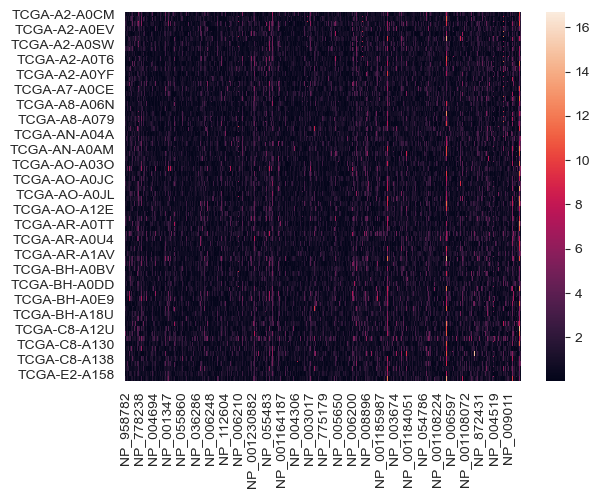

array([1.30576328e-01, 9.07500236e-02, 7.28796888e-02, 4.53448190e-02,
       4.00247766e-02, 3.66438860e-02, 2.56499257e-02, 2.25723269e-02,
       2.23460683e-02, 2.19393066e-02, 1.89472433e-02, 1.78469258e-02,
       1.72004717e-02, 1.61434145e-02, 1.53635727e-02, 1.44440133e-02,
       1.35311801e-02, 1.31498118e-02, 1.26913088e-02, 1.22654475e-02,
       1.16084167e-02, 1.13927426e-02, 1.07685742e-02, 1.04016606e-02,
       1.01833599e-02, 9.69736465e-03, 9.34327369e-03, 9.28792973e-03,
       9.03719834e-03, 8.85408943e-03, 8.66973906e-03, 8.34348147e-03,
       8.14334488e-03, 7.92488402e-03, 7.77397828e-03, 7.56413045e-03,
       7.33569351e-03, 7.25306519e-03, 7.14839092e-03, 6.97477463e-03,
       6.76230853e-03, 6.72655672e-03, 6.63901123e-03, 6.48243311e-03,
       6.33950966e-03, 6.15434532e-03, 5.97300314e-03, 5.89799451e-03,
       5.79984312e-03, 5.70884541e-03, 5.67750504e-03, 5.39897246e-03,
       5.34139430e-03, 5.29778687e-03, 5.20080759e-03, 5.00256568e-03,
      

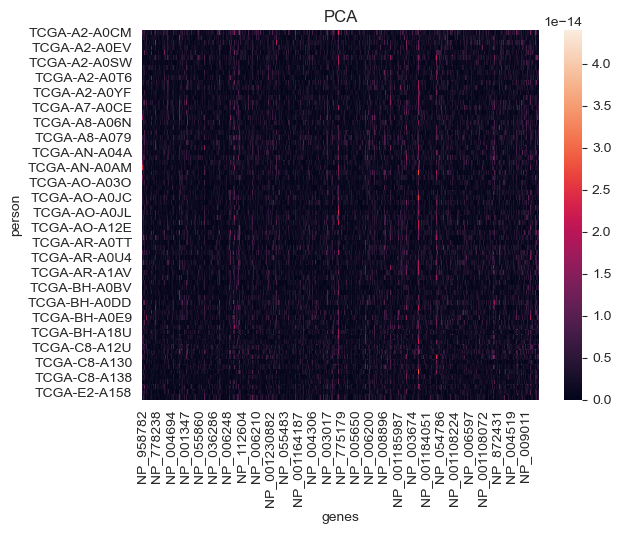

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# PCA)
from sklearn.decomposition import  PCA

pca = PCA(n_components = 74, svd_solver = 'full')
pca.fit(y_scaled)
pca.fit_transform(y_scaled).shape

sns.heatmap(np.abs(y_scaled))
plt.show()
sns.heatmap(np.abs((y_scaled-pca.inverse_transform(pca.fit_transform(y_scaled)))))
plt.xlabel("genes")
plt.ylabel("person")
plt.title("PCA")


np.linalg.matrix_rank(pca.inverse_transform(pca.fit_transform(y_scaled)))
pca.explained_variance_ratio_

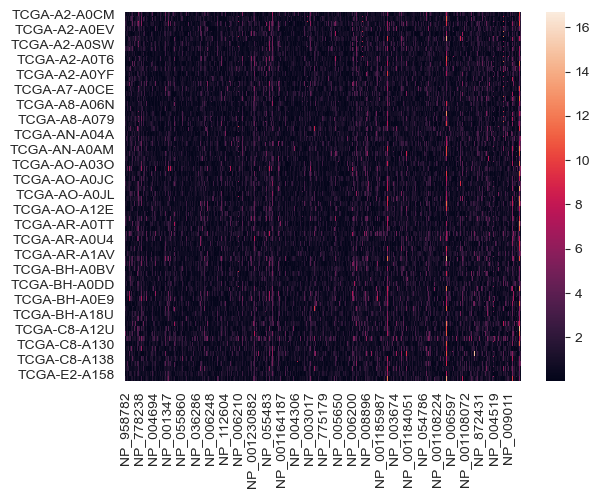

74

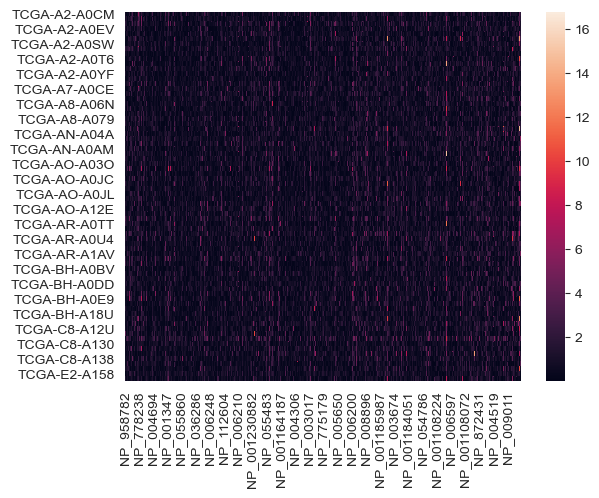

In [13]:
import seaborn as sns

# K-PCA, 
from sklearn.decomposition import  KernelPCA

# kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘cosine’, ‘precomputed’}
kpca = KernelPCA(n_components = 73, kernel='rbf', fit_inverse_transform=True)
kpca.fit(y_scaled)

sns.heatmap(np.abs(y_scaled))
plt.show()
sns.heatmap(np.abs((y_scaled-kpca.inverse_transform(kpca.transform(y_scaled)))))
np.linalg.matrix_rank(kpca.inverse_transform(kpca.transform(y_scaled)))

In [14]:
# or tSNE

In [15]:

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42)
X_train.head()

,Gender,Age at Initial Pathologic Diagnosis,ER Status,PR Status,HER2 Final Status,Tumor,Tumor--T1 Coded,Node,Node-Coded,Metastasis,...,PAM50 mRNA,SigClust Unsupervised mRNA,SigClust Intrinsic mRNA,miRNA Clusters,methylation Clusters,RPPA Clusters,CN Clusters,Integrated Clusters (with PAM50),Integrated Clusters (no exp),Integrated Clusters (unsup exp)
TCGA-AO-A12E,FEMALE,51,Positive,Positive,Negative,T3,T_Other,N0,Negative,M0,...,Luminal A,-7,-5,1,3,LumA/B,3,3,4,3
TCGA-D8-A142,FEMALE,74,Negative,Negative,Negative,T3,T_Other,N0,Negative,M0,...,Basal-like,0,-13,3,5,X,1,2,2,2
TCGA-A7-A0CJ,FEMALE,57,Positive,Positive,Negative,T2,T_Other,N0,Negative,M0,...,Luminal B,-3,-6,2,3,LumA/B,1,4,4,3
TCGA-AO-A0JJ,FEMALE,54,Positive,Positive,Negative,T2,T_Other,N1,Positive,M0,...,Luminal A,-7,-5,7,1,LumA/B,2,3,3,4
TCGA-AR-A0TX,FEMALE,64,Positive,Positive,Positive,T1,T1,N1,Positive,M0,...,HER2-enriched,-5,-11,1,1,ReacII,1,1,2,2
